In [3]:
%reload_kedro

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2021-05-31 10:18:20,257 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-05-31 10:18:20,296 - root - INFO - ** Kedro project Foehn fire impact
2021-05-31 10:18:20,297 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-05-31 10:18:20,305 - root - INFO - Registered line magic `run_viz`


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
from utils import *
import kedro.framework.context

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

In [7]:
df = context.catalog.load("fire_data_with_foehn_and_control_variables")

2021-05-31 10:18:27,221 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


In [8]:
foehn_prevalence_fire_start = (df["foehn_minutes_during_12_hours_after_start_of_fire"] >0).sum()/df["foehn_minutes_during_12_hours_after_start_of_fire"].count()
foehn_prevalence_before_fire_start = (df["foehn_minutes_24_hour_before"] >0).sum()/df["foehn_minutes_24_hour_before"].count()

print(f"Foehn prevalent 12h after start of fire (%): {foehn_prevalence_fire_start}")
print(f"Foehn prevalent 24h before start of fire (%): {foehn_prevalence_before_fire_start}")

Foehn prevalent 12h after start of fire (%): 0.27358490566037735
Foehn prevalent 24h before start of fire (%): 0.37856829161176986


Fires longer than 6h (%): 0.2895263509006004
Fires longer than 12h (%): 0.19513008672448298


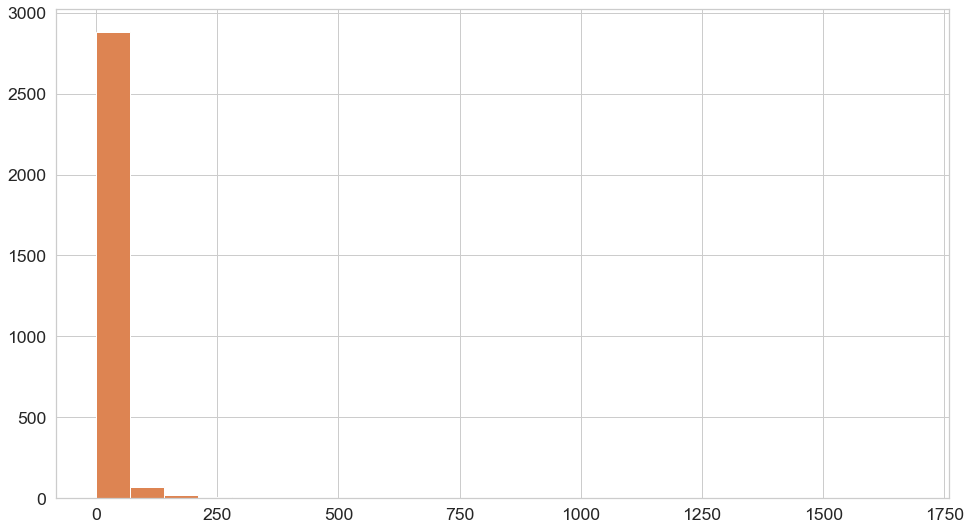

In [9]:
(df["duration_min"]).hist(bins=24)
(df["duration_max"]).hist(bins=24)

print(f"Fires longer than 6h (%): {(df['duration_min']> 6).sum()/df['duration_min'].count()}")
print(f"Fires longer than 12h (%): {(df['duration_min'] > 12).sum()/df['duration_min'].count()}")
#print(f"Foehn prevalent 24h before start of fire (%): {foehn_prevalence_before_fire_start}")

In [10]:
# df_dummy = context.catalog.load("raw_fire_data").loc[:, ["start date", "start date (solar time)", "accuracy start date"]]#["start date (solar time)"]#.dt.hour.hist(bins=24)
# df_dummy.loc[(( df_dummy["start date"] - df_dummy["start date (solar time)"] ) == pd.Timedelta(hours=1)), :]

In [11]:
df.loc[:, "potential_foehn_species"].value_counts(dropna=False, normalize=True)

North foehn    0.801868
South foehn    0.198132
Name: potential_foehn_species, dtype: float64

# After fire ignition

In [ ]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [6,12]:
        plot_multiple_binned_burned_area_after_fire_start(df, hours=hours, control_var=var)  

In [ ]:
test_multiple_bins_against_no_foehn(df, hours=12)

In [ ]:
# All fires
for hours in [6,12]:
    test_binary_bins(df, hours=hours)

In [ ]:
control_var_categories = {"": "",
                          "fire_regime": ["Winter anthropogenic", "Summer anthropogenic", "Summer natural"], 
                          "decade": ["[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]"],
                          "potential_foehn_species": ["North foehn", "South foehn"]}

In [ ]:
# For different fire regimes regimes
var = "fire_regime"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

In [ ]:
# For different foehn types
var = "potential_foehn_species"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

In [ ]:
# Test for significant difference between North and South Foehn
var = "potential_foehn_species"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = control_var_categories[var])

In [ ]:
# For different decades
var = "decade"
for hours in [6,12]:
    test_binary_bins(df, hours=hours, control_var=var, categories = control_var_categories[var])
    plot_binary_binned_burned_area_after_fire_start(df, hours=hours,control_var=var)

In [ ]:
# Test for significant difference in foehn between decades
var = "decade"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = control_var_categories[var][1:4])

southern_switzerland    2418
valais                   203
east_switzerland         142
NaN                      127
central_switzerland      108
Name: region, dtype: int64
region
southern_switzerland    494
east_switzerland         20
valais                   18
central_switzerland      11
Name: With foehn influence (6h after start), dtype: int64


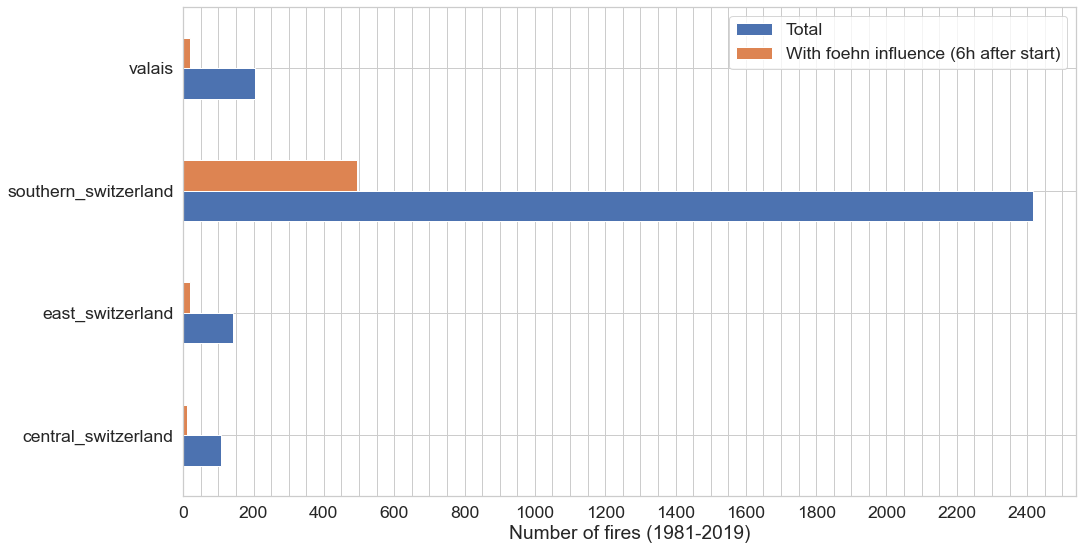

In [45]:
# Predefined regions and stations therein
# Eliminated stations: 
regions = context.config_loader.get("regions.json")

for region in regions.keys():
    for station in regions[region]:
        df.loc[(df["closest_station"] == station), "region"] = region
    
df_total = df.groupby("region").count()["total [ha]"].rename("Total")
df_onlyfoehn = df.loc[df["foehn_minutes_during_6_hours_after_start_of_fire"]>0, :].groupby("region").count()["total [ha]"].rename("With foehn influence (6h after start)")
pd.concat([df_total, df_onlyfoehn], axis=1).plot(kind="barh")
plt.xlabel("Number of fires (1981-2019)")
plt.ylabel("")
plt.xticks(range(0,2550, 50), labels=[str(i) if i%200 == 0 else "" for i in range(0,2550, 50)])
print(df["region"].value_counts(dropna=False, normalize=False))

print(df_onlyfoehn.sort_values(ascending=False))

## Wind strength influence

southern_switzerland
Amount of foehn-influenced fires:  494
(6h) (2.5, 14.9] (288) vs. (14.9, 27.6] (175) 	 0.006104 	 3.636
(6h) (2.5, 14.9] (288) vs. (27.6, 52.0] (31) 	 0.000232 	 18.182
(6h) (14.9, 27.6] (175) vs. (27.6, 52.0] (31) 	 0.013962 	 5.0
Amount of foehn-influenced fires:  533
(12h) (1.0, 10.7] (238) vs. (10.7, 21.0] (226) 	 0.034663 	 4.0
(12h) (1.0, 10.7] (238) vs. (21.0, 52.0] (69) 	 0.001364 	 10.0
(12h) (10.7, 21.0] (226) vs. (21.0, 52.0] (69) 	 0.050203 	 2.5


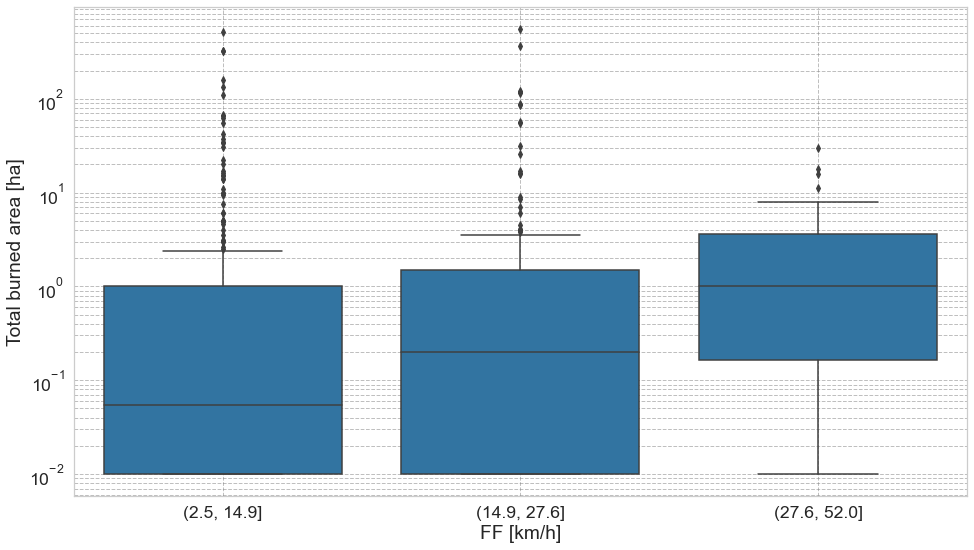

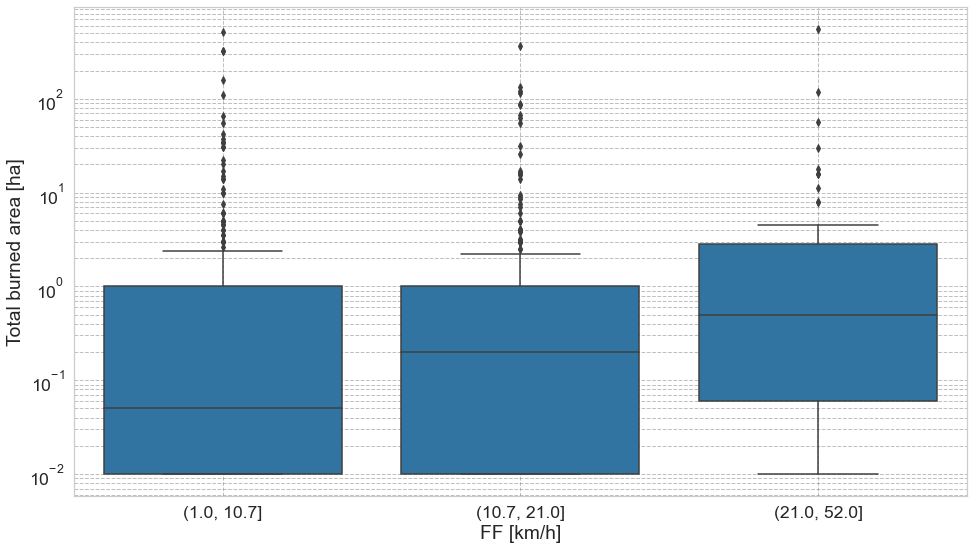

In [77]:
bins_dict = {6: [2.5,14.9,27.6,52], 12: [1,10.7,21,52]}
#bins_dict = {6: [5,10,15,20], 12: [5,10,15,20]}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength(df.loc[df["region"] == region, :], hours=hour, strength_var="FF", bins=bins_dict[hour])
    break  

<AxesSubplot:>

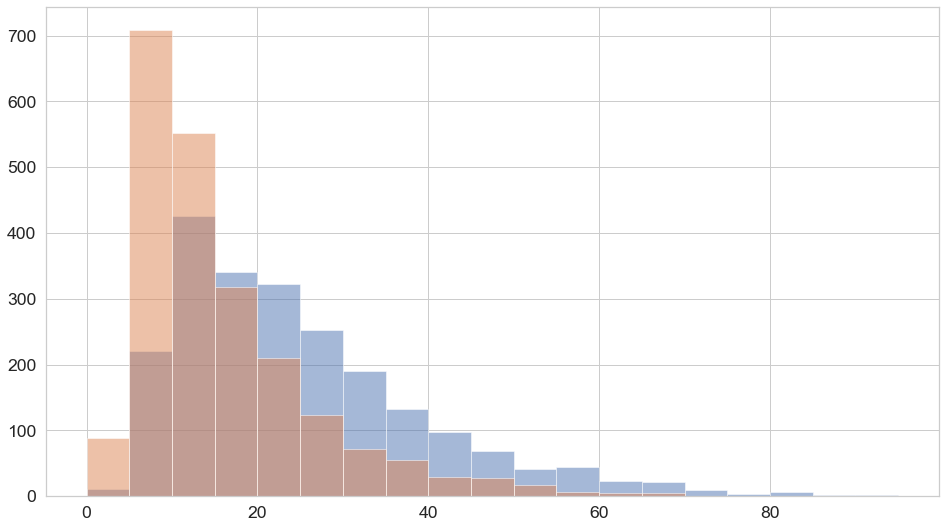

In [103]:
(df[f"FFX_q90_during_12_hours_after_start_of_fire"]).hist(bins=range(0,100,5), alpha=0.5)
(df[f"FFX_mean_during_12_hours_after_start_of_fire"]).hist(bins=range(0,100,5), alpha=0.5)

southern_switzerland
Amount of foehn-influenced fires:  494
(6h) (7.5, 27.0] (148) vs. (27.0, 52.1] (263) 	 0.02647 	 4.0
(6h) (7.5, 27.0] (148) vs. (52.1, 95.0] (82) 	 0.001521 	 8.1
(6h) (27.0, 52.1] (263) vs. (52.1, 95.0] (82) 	 0.123522 	 2.025
Amount of foehn-influenced fires:  533
(12h) (3, 21] (103) vs. (21, 35] (229) 	 0.742317 	 1.429
(12h) (3, 21] (103) vs. (35, 95] (201) 	 0.002368 	 4.429
(12h) (21, 35] (229) vs. (35, 95] (201) 	 0.001649 	 3.1


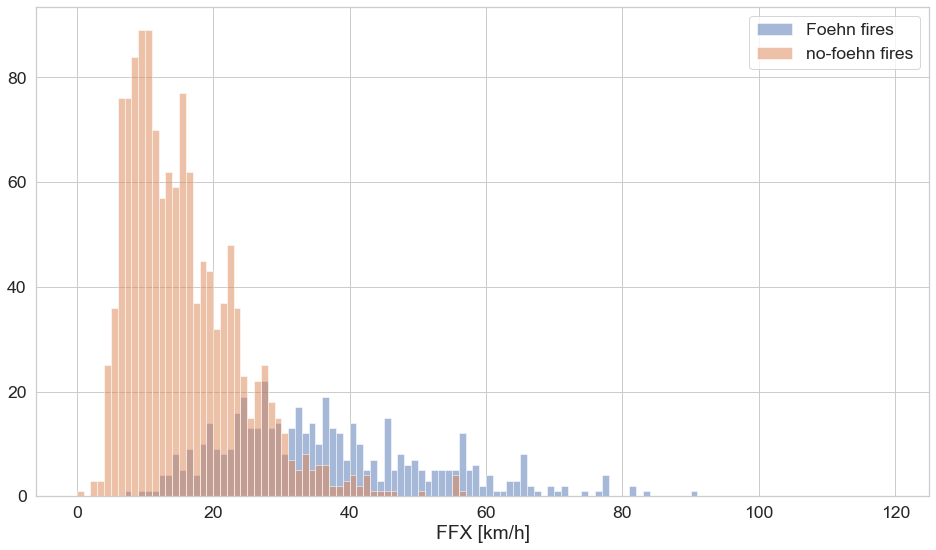

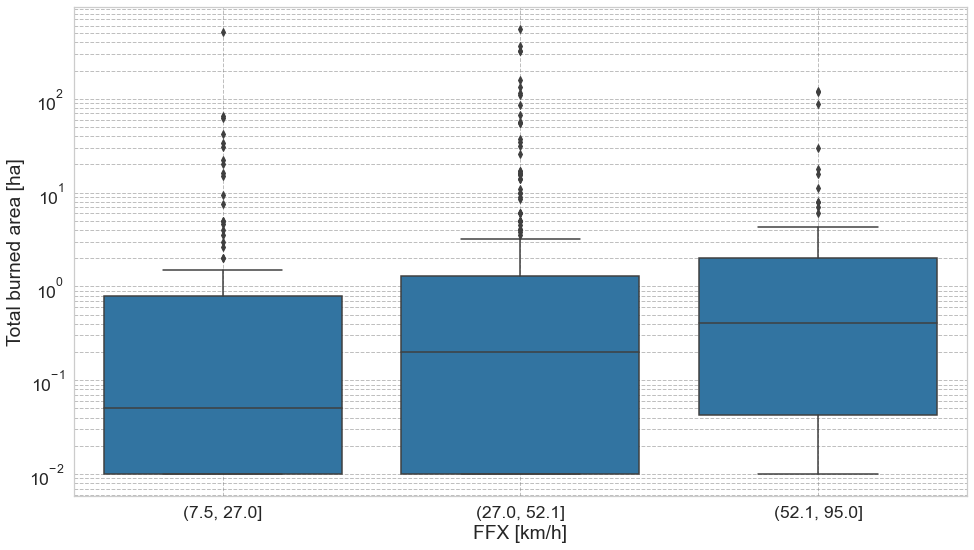

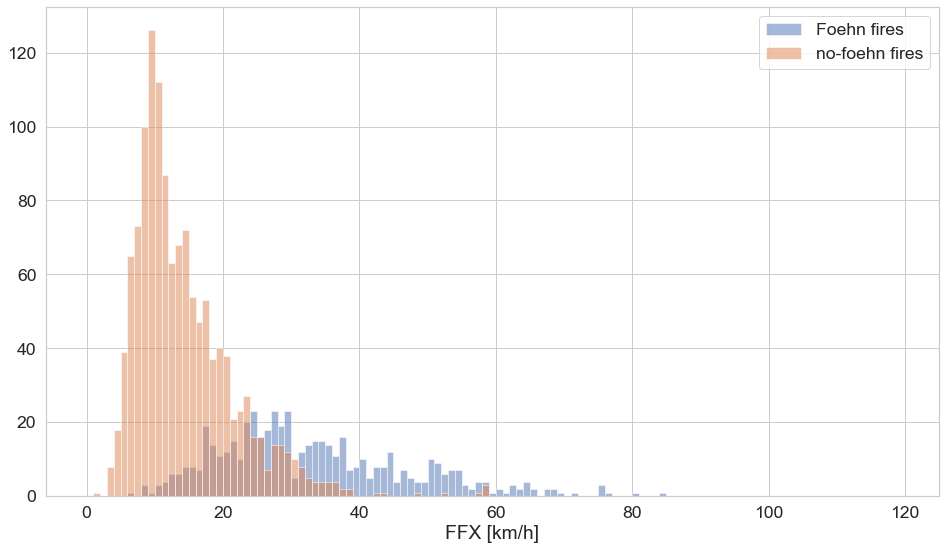

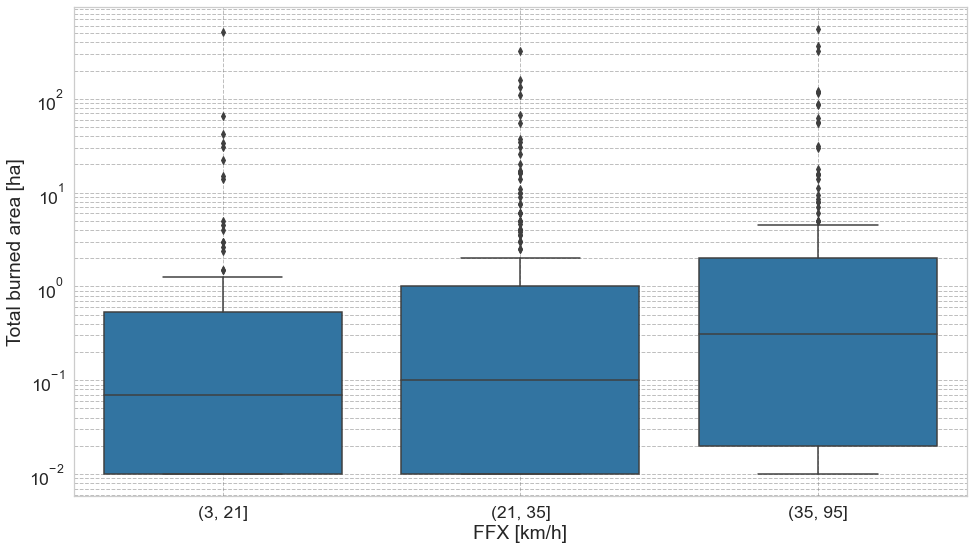

In [95]:
bins_dict = {6: [7.5,27,52.1,95], 12: [3,21,35,95]}
#bins_dict = {6: [15,20, 25, 30], 12: [10,15,20, 25]}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength(df.loc[df["region"] == region, :], hours=hour, strength_var="FFX", bins=bins_dict[hour])
    break

### Compare to non-foehn

southern_switzerland
Amount of foehn-influenced fires:  494
Amount of non-foehn-influenced fires:  1344
(6h) (0.0, 5.0] (foehnfires: 19), (nofoehnfires: 553) 	 0.516517
(6h) (5.0, 10.0] (foehnfires: 120), (nofoehnfires: 581) 	 0.259856
(6h) (10.0, 15.0] (foehnfires: 150), (nofoehnfires: 154) 	 0.407262
(6h) (15.0, 20.0] (foehnfires: 95), (nofoehnfires: 38) 	 0.216757
(6h) (20.0, 25.0] (foehnfires: 57), (nofoehnfires: 14) 	 0.082879
(6h) (25.0, 30.0] (foehnfires: 36), (nofoehnfires: 1) 	 0.189783
(6h) (30.0, 35.0] (foehnfires: 11), (nofoehnfires: 0) 	 nan
Amount of foehn-influenced fires:  533
Amount of non-foehn-influenced fires:  1305


/home/chmony/Apps/anaconda3/envs/foehnfirecorr/lib/python3.8/site-packages/scipy/stats/stats.py:7246: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(12h) (0.0, 5.0] (foehnfires: 17), (nofoehnfires: 630) 	 0.105088
(12h) (5.0, 10.0] (foehnfires: 188), (nofoehnfires: 566) 	 0.385055
(12h) (10.0, 15.0] (foehnfires: 169), (nofoehnfires: 90) 	 0.297553
(12h) (15.0, 20.0] (foehnfires: 81), (nofoehnfires: 10) 	 0.002089
(12h) (20.0, 25.0] (foehnfires: 52), (nofoehnfires: 6) 	 0.645819
(12h) (25.0, 30.0] (foehnfires: 20), (nofoehnfires: 0) 	 nan


/home/chmony/Apps/anaconda3/envs/foehnfirecorr/lib/python3.8/site-packages/scipy/stats/stats.py:7246: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


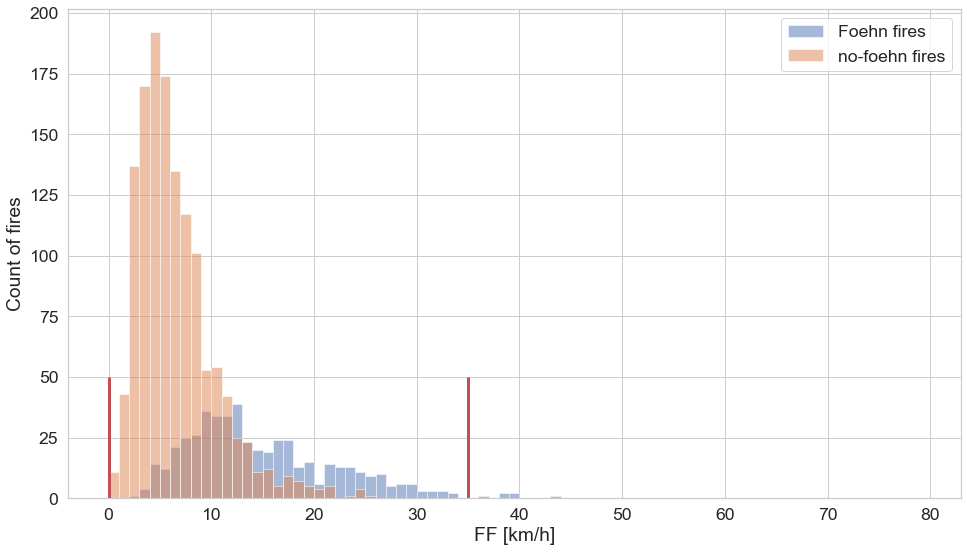

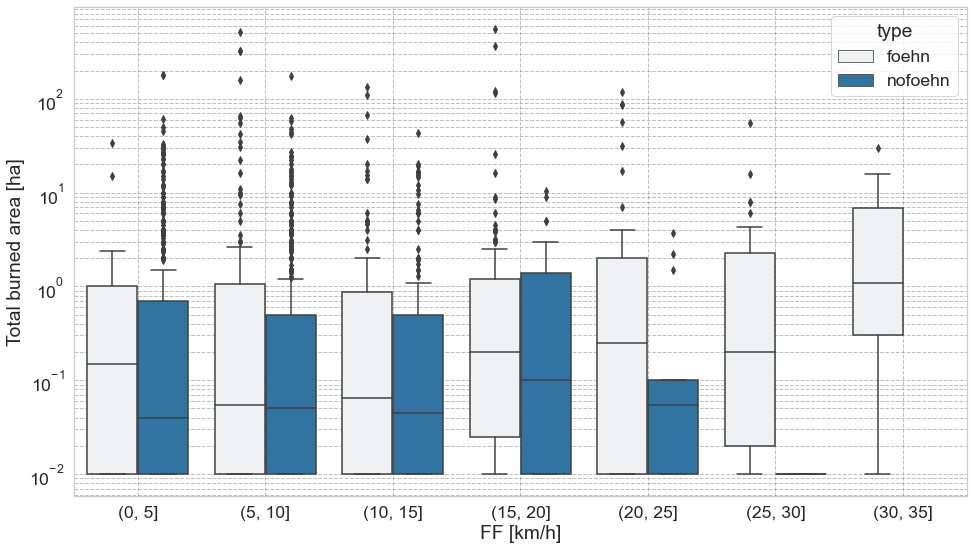

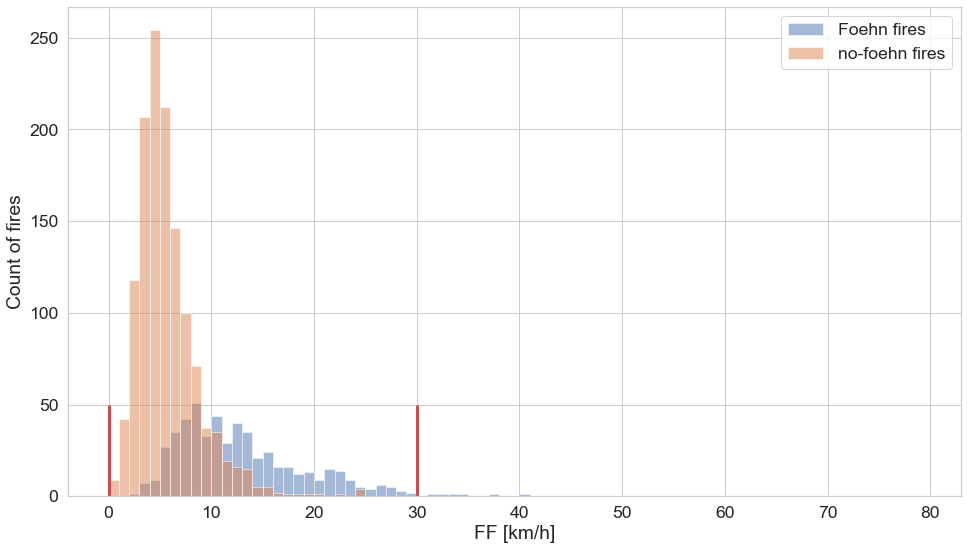

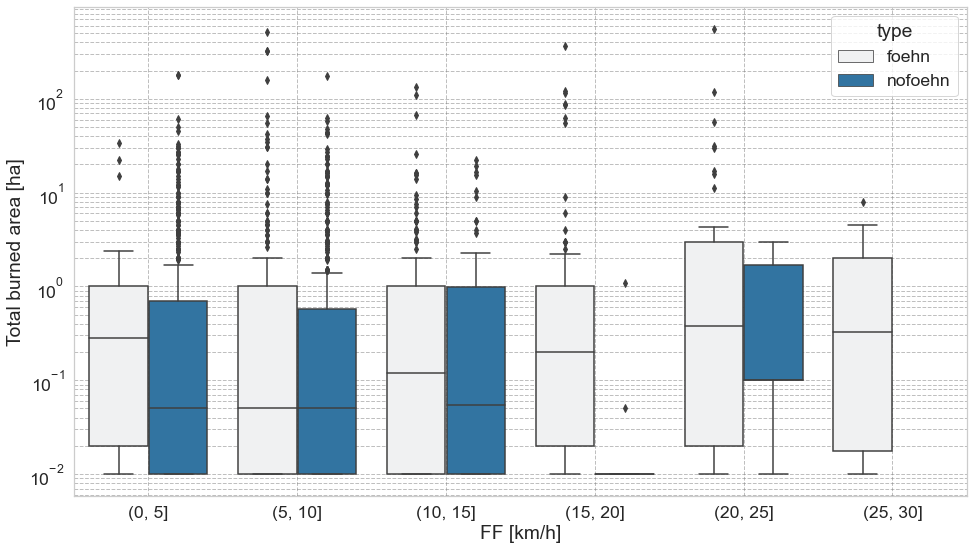

In [79]:
# OLD: bins_dict = {6: [5,6,11,60], 12: [0,6,10,60]}
bins_dict = {6: range(0,35+1,5), 12: range(0,30+1,5)}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength_foehn_nofoehn(df.loc[df["region"] == region, :].copy(), hours=hour, strength_var="FF", bins=bins_dict[hour])
    break

southern_switzerland
Amount of foehn-influenced fires:  494
Amount of non-foehn-influenced fires:  1339
(6h) (0.0, 5.0] (foehnfires: 0), (nofoehnfires: 85) 	 nan
(6h) (5.0, 10.0] (foehnfires: 5), (nofoehnfires: 507) 	 0.963657
(6h) (10.0, 15.0] (foehnfires: 38), (nofoehnfires: 360) 	 0.256675
(6h) (15.0, 20.0] (foehnfires: 65), (nofoehnfires: 202) 	 0.349612
(6h) (20.0, 25.0] (foehnfires: 93), (nofoehnfires: 99) 	 0.080757
(6h) (25.0, 30.0] (foehnfires: 76), (nofoehnfires: 52) 	 0.710526
(6h) (30.0, 35.0] (foehnfires: 56), (nofoehnfires: 18) 	 0.781647
(6h) (35.0, 40.0] (foehnfires: 43), (nofoehnfires: 6) 	 0.552014


/home/chmony/Apps/anaconda3/envs/foehnfirecorr/lib/python3.8/site-packages/scipy/stats/stats.py:7246: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/home/chmony/Apps/anaconda3/envs/foehnfirecorr/lib/python3.8/site-packages/scipy/stats/stats.py:7246: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(6h) (40.0, 45.0] (foehnfires: 45), (nofoehnfires: 1) 	 0.47425
(6h) (45.0, 50.0] (foehnfires: 15), (nofoehnfires: 2) 	 0.156724
(6h) (50.0, 55.0] (foehnfires: 29), (nofoehnfires: 4) 	 0.639171
(6h) (55.0, 60.0] (foehnfires: 11), (nofoehnfires: 0) 	 nan
Amount of foehn-influenced fires:  533
Amount of non-foehn-influenced fires:  1300


/home/chmony/Apps/anaconda3/envs/foehnfirecorr/lib/python3.8/site-packages/scipy/stats/stats.py:7246: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


(12h) (0.0, 5.0] (foehnfires: 0), (nofoehnfires: 76) 	 nan
(12h) (5.0, 10.0] (foehnfires: 16), (nofoehnfires: 605) 	 0.286163
(12h) (10.0, 15.0] (foehnfires: 68), (nofoehnfires: 388) 	 0.473507
(12h) (15.0, 20.0] (foehnfires: 99), (nofoehnfires: 145) 	 0.15736
(12h) (20.0, 25.0] (foehnfires: 110), (nofoehnfires: 58) 	 0.701238
(12h) (25.0, 30.0] (foehnfires: 81), (nofoehnfires: 15) 	 0.012871
(12h) (30.0, 35.0] (foehnfires: 50), (nofoehnfires: 3) 	 0.743543
(12h) (35.0, 40.0] (foehnfires: 40), (nofoehnfires: 2) 	 0.06711
(12h) (40.0, 45.0] (foehnfires: 25), (nofoehnfires: 1) 	 0.182422
(12h) (45.0, 50.0] (foehnfires: 22), (nofoehnfires: 1) 	 1.0
(12h) (50.0, 55.0] (foehnfires: 9), (nofoehnfires: 3) 	 0.92634


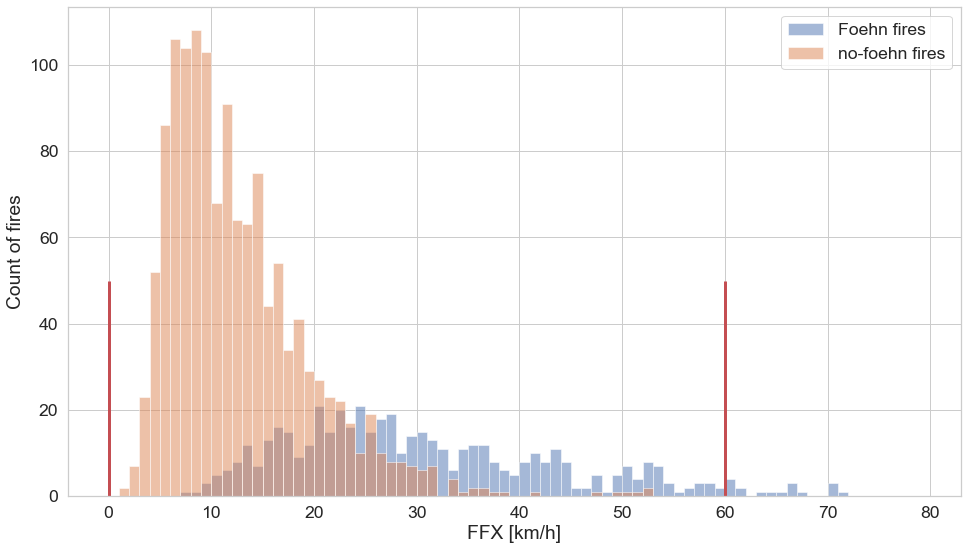

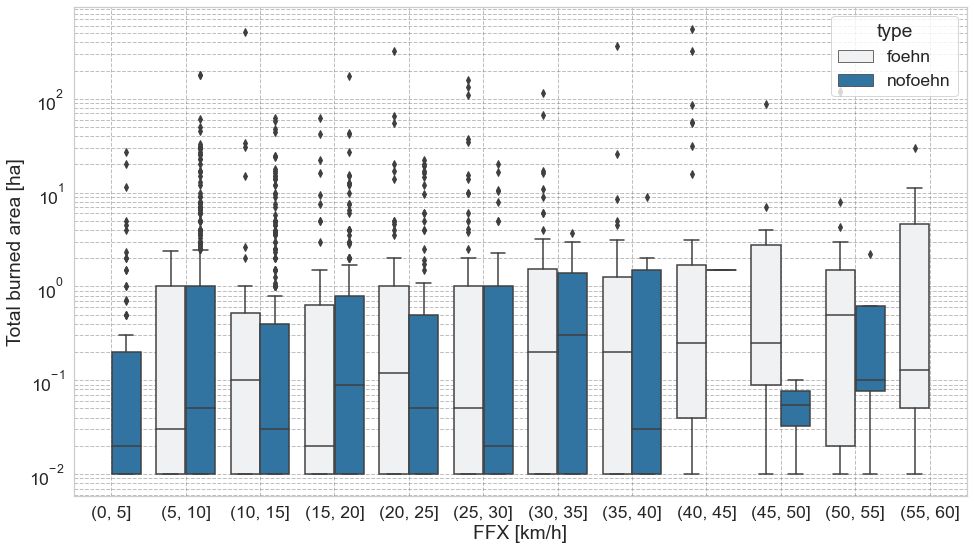

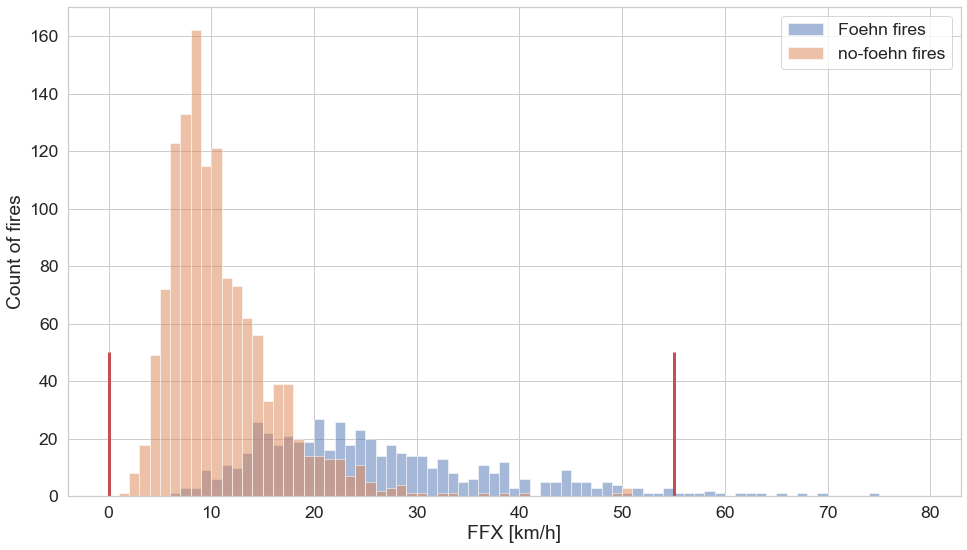

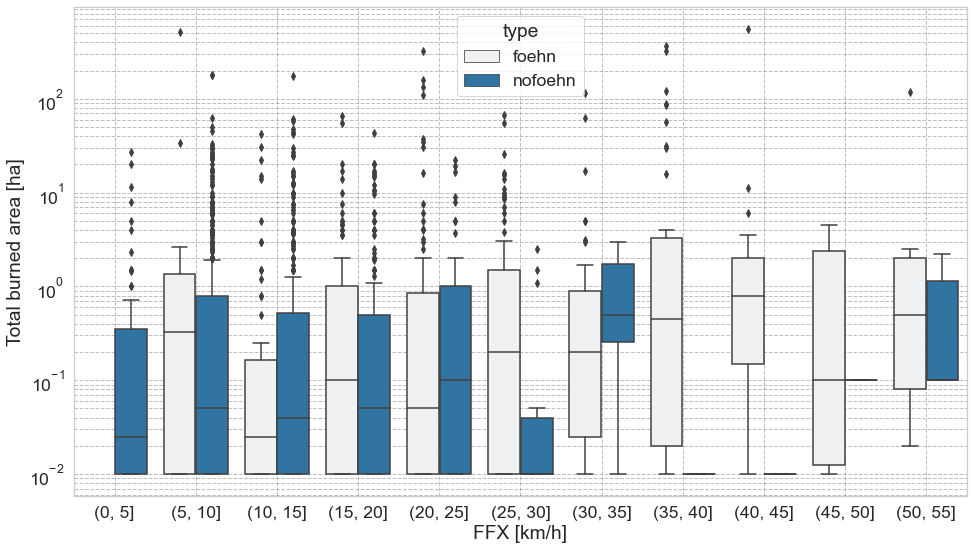

In [13]:
# OLD: bins_dict = {6: [5,6,11,60], 12: [0,6,10,60]}
bins_dict = {6: range(0,60+1,5), 12: range(0,55+1,5)}
for region in regions.keys():
    print(region)
    for hour in [6,12]:
        test_foehn_strength_foehn_nofoehn(df.loc[df["region"] == region, :].copy(), hours=hour, strength_var="FFX", bins=bins_dict[hour])
    break

# Before fire ignition

In [ ]:
df_foehn = context.catalog.load("foehn_data_prepared")

In [ ]:
df_rain = context.catalog.load("rain_data")

# Since rain data goes from 0700 to 0700 the next day (Swiss time). Move to file at some point.
df_rain["date"] = df_rain["date"] + pd.Timedelta(hours=12) + pd.Timedelta(days=1)

In [ ]:
df_merge = pd.merge(df_foehn, df_rain, on ="date", how="left")
#df_merge["date"] = df_merge["date"] + pd.Timedelta(hours=-100)

In [ ]:
df_foehn.loc[df_foehn["LUG_foehn"]==1, "date"].dt.year.hist(bins=38)
#df.loc[df["region"]=="tessin", "start_date_min"].dt.hour.hist(bins=24)

In [ ]:
# Before fire start
for region in regions.keys():
    print(region)
    plot_binned_fire_count_before_fire_start(df.loc[df["region"] == region, :], df_foehn=df_merge, hours=24, stations_in_region=regions[region])
    break

## Temperature influence

In [ ]:
stations = [colname[0:3] for colname in df_foehn.filter(regex="foehn").columns]
north_foehn_stations = ["LUG", "OTL", "MAG", "COM", "GRO", "SBO", "PIO", "CEV", "ROB", "VIO"]
south_foehn_stations = set(stations) - set(north_foehn_stations)

for hour in [24,48]:
    plot_binned_fire_count_before_fire_start_temperature(df, df_foehn, hours=hour, stations=north_foehn_stations)

# Experimental

In [ ]:
df_foehn_copy=df_foehn.filter(regex="(foehn|TT)").copy() 
foehn_cols = df_foehn_copy.filter(regex="foehn").columns
temp_cols = df_foehn_copy.filter(regex="TT").columns

In [ ]:
df_foehn_copy.index = df_foehn["date"]

In [ ]:
df_foehn_copy = df_foehn_copy.between_time("18:00", "6:00", include_start=False, include_end=True)
df_foehn_copy.index = df_foehn_copy.index + pd.Timedelta("6h")

In [ ]:
group = df_foehn_copy.groupby(by=df_foehn_copy.index.date)
df_temp = group[temp_cols].first()- group[temp_cols].min()
df_f = group[foehn_cols].sum()*10
df_final = pd.concat([df_temp, df_f], axis=1)
df_final

In [ ]:
sns.histplot(df_final.loc[df_final["ALT_foehn"] >= 10, "ALT_TT"], stat="density", bins=range(0,15), color="r")
sns.histplot(df_final.loc[df_final["ALT_foehn"] == 0, "ALT_TT"],stat="density", bins=range(0,15))

In [ ]:
for i in df.index:
    station = df.loc[i, "closest_station"]
    start_date = pd.to_datetime(df.loc[i, "start date (solar time)"]).date()
    if start_date.year >1981:
        df.loc[i, "temp_decrease_during_night"] = df_final.loc[start_date, f"{station}_TT"]
        df.loc[i, "foehn_minutes_during_night"] = df_final.loc[start_date, f"{station}_foehn"]
    

In [ ]:
sns.histplot(df.loc[df["foehn_minutes_during_night"]>300, "temp_decrease_during_night"],bins=range(0,15),  color="r")
sns.histplot(df.loc[df["foehn_minutes_during_night"]==0, "temp_decrease_during_night"],bins=range(0,15))

In [ ]:
df_local = df.loc[df["foehn_minutes_during_night"]>0, :]

intervals = pd.cut(df_local["temp_decrease_during_night"], bins=6).value_counts().index
print(intervals.categories)

count_of_intervals = np.zeros(len(intervals))
print(count_of_intervals)
for col in temp_cols:
    station = col[0:3]
    if station == "GUE":
        continue
    df_loop = df_final.loc[df_final[f"{station}_foehn"]>0, :]
    #print(pd.cut(df_loop[col], bins=intervals.categories).value_counts())
    count_of_intervals = pd.cut(df_loop[col], bins=intervals.categories).value_counts()
    df_count = pd.cut(df_local.loc[df_local["closest_station"] == station, "temp_decrease_during_night"], bins=intervals.categories).value_counts(sort=False)
    plt.figure()
    sns.barplot(x=df_count.index, y=df_count/count_of_intervals)
    
# print(count_of_intervals/40)

# df_count = pd.cut(df_local["temp_decrease_during_night"], bins=6).value_counts(sort=False)
# print(df_count)
# print(df_count/count_of_intervals)
# sns.barplot(df_count.index, df_count/count_of_intervals*40)

In [ ]:
count_of_intervals

# Impact of foehn duration before fire on burned area

In [ ]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        plot_multiple_binned_burned_area_after_fire_start(df, hours=hours, variable="before", control_var=var)  

In [ ]:
# Plot all (or selected) plots for 6 and 12 hours after fire start
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        plot_binary_binned_burned_area_after_fire_start(df, hours=hours, variable="before", control_var=var)  

In [ ]:
for var in ["", "decade", "fire_regime", "potential_foehn_species"]:
    for hours in [24,48]:
        test_binary_bins(df, hours=hours, variable="before", control_var=var, categories = control_var_categories[var])

In [ ]:
plot_binned_burned_area_before_and_after_fire_start(df, hours_before=24, hours_after=6)